<a href="https://colab.research.google.com/github/zanderVenter/GEE_misc/blob/master/multiclass_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install -r requirements.txt -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tfswin 3.4.0 requires keras>=2.13.0, but you have keras 2.11.0 which is incompatible.
tfswin 3.4.0 requires tensorflow>=2.13.0, but you have tensorflow 2.11.0 which is incompatible.
tensorboardx 2.6.2.2 requires protobuf>=3.20, but you have protobuf 3.19.4 which is incompatible.
onnx 1.16.0 requires protobuf>=3.20.2, but you have protobuf 3.19.4 which is incompatible.
gluonts 0.13.7 requires pydantic~=1.7, but you have pydantic 2.5.1 which is incompatible.
autogluon-timeseries 0.8.2 requires networkx<4,>=3.0, but you have networkx 2.8.4 which is incompatible.
autogluon-timeseries 0.8.2 requires pandas<1.6,>=1.4.1, but you have pandas 2.2.2 which is incompatible.
autogluon-timeseries 0.8.2 requires pytorch-lightning<1.10.0,>=1.7.4, but you have pytorch-lightning 2.2.1 which is incompatible.
autogluon-timeseries 0.8

Import relevant libraries for this starter script:

In [2]:
import os
import rioxarray as rxr
import rasterio as rio
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from matplotlib.patches import Patch
import numpy as np
from pathlib import Path
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import jaccard_score

2024-06-18 21:30:43.583473: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
root = Path('/cluster/home/taheeraa/code/test-multiclass-segmentation/dset-s2-grunnkart')
assert root.exists()

train_imgs = list((root/'tra_scene').glob('*.tif'))
train_masks = list((root/'tra_truth').glob('*.tif'))

val_imgs = list((root/'val_scene').glob('*.tif'))
val_masks = list((root/'val_truth').glob('*.tif'))

# As the images and corresponding masks are matched by name, we will sort both lists to keep them synchronized.
train_imgs.sort(); train_masks.sort(); val_imgs.sort(); val_masks.sort()

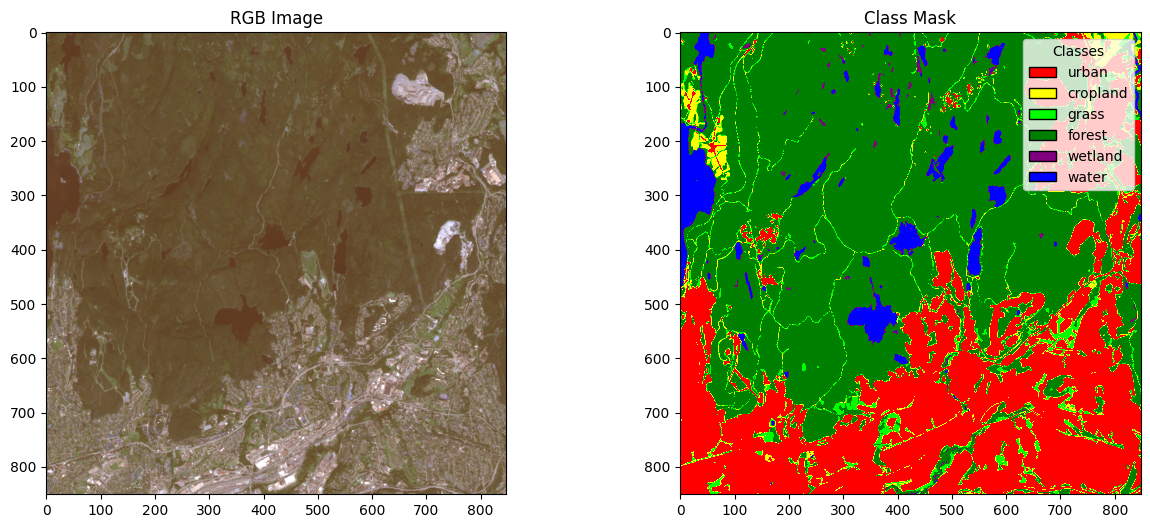

In [4]:
idx = 0
img = rxr.open_rasterio(train_imgs[idx])
mask = rxr.open_rasterio(train_masks[idx])

_, axs = plt.subplots(1, 2, figsize=(15, 6))

# Define the class labels and corresponding colors
class_labels = ['urban', 'cropland', 'grass', 'forest', 'wetland', 'water']
class_colors = ['red', 'yellow', 'lime', 'green', 'purple', 'blue']

# plot the tile
rgb = img.data[[2, 1, 0]].transpose((1, 2, 0))/2000
axs[0].imshow(rgb.clip(min=0, max=1))
axs[0].set_title("RGB Image")

# plot the mask
axs[1].imshow(mask.data.squeeze(), cmap=ListedColormap(class_colors))
axs[1].set_title("Class Mask")
legend_elements = [Patch(facecolor=color, edgecolor='black', label=label)
                   for color, label in zip(class_colors, class_labels)]

# Add the legend to the second subplot
axs[1].legend(handles=legend_elements, loc='upper right', title="Classes")

# understand the data?

In [5]:
img

<xarray.DataArray (band: 6, y: 851, x: 848)> Size: 17MB
array([[[ 406,  403, ...,  354,  530],
        [ 435,  413, ...,  324,  412],
        ...,
        [ 918, 1064, ...,  720,  688],
        [1236, 1155, ...,  843,  832]],

       [[ 755,  732, ...,  600,  882],
        [ 789,  733, ...,  552,  686],
        ...,
        [ 964,  975, ...,  818,  827],
        [1261, 1181, ...,  964,  934]],

       ...,

       [[1200,  948, ..., 1389, 1700],
        [1425, 1232, ..., 1129, 1700],
        ...,
        [1728, 1811, ...,  984,  767],
        [1728, 1811, ...,  767,  767]],

       [[7658, 7224, ..., 5826, 6880],
        [7907, 7425, ..., 5527, 6246],
        ...,
        [3523, 2909, ..., 1012,  233],
        [2339, 2663, ...,  442,  219]]], dtype=int32)
Coordinates:
  * band         (band) int64 48B 1 2 3 4 5 6
  * x            (x) float64 7kB 2.649e+05 2.649e+05 ... 2.734e+05 2.734e+05
  * y            (y) float64 7kB 6.66e+06 6.66e+06 ... 6.652e+06 6.652e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      ('red', 'green', 'blue', 'nir', 'swir1', 'ndvi')

# preprocess data

In [58]:
import numpy as np
import rioxarray as rxr
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img

# Define the target size
target_size = (256, 256)

def preprocess_images(image_files, target_size):
    images = []
    for file in image_files:
        img = rxr.open_rasterio(file)
        rgb = img.data[[2, 1, 0]].transpose((1, 2, 0)) / 2000
        rgb = rgb.clip(min=0, max=1)
        rgb_resized = array_to_img(img_to_array(rgb)).resize(target_size)
        images.append(img_to_array(rgb_resized))
    return np.array(images)

def preprocess_masks(mask_files, num_classes, target_size):
    masks = []
    for file in mask_files:
        mask = rxr.open_rasterio(file).data.squeeze()
        mask_resized = array_to_img(img_to_array(mask)).resize(target_size)
        mask_resized_array = img_to_array(mask_resized)
        mask_resized_array[mask_resized_array >= num_classes] = num_classes - 1  # Handle invalid class indices
        masks.append(to_categorical(mask_resized_array, num_classes=num_classes))
    return np.array(masks, dtype=np.float32)

# Load and preprocess the data
X_train = preprocess_images(train_imgs, target_size)
y_train = preprocess_masks(train_masks, num_classes=6, target_size=target_size)
X_val = preprocess_images(val_imgs, target_size)
y_val = preprocess_masks(val_masks, num_classes=6, target_size=target_size)

In [67]:
len(X_train), len(y_val)

(4, 2)

Training set samples:


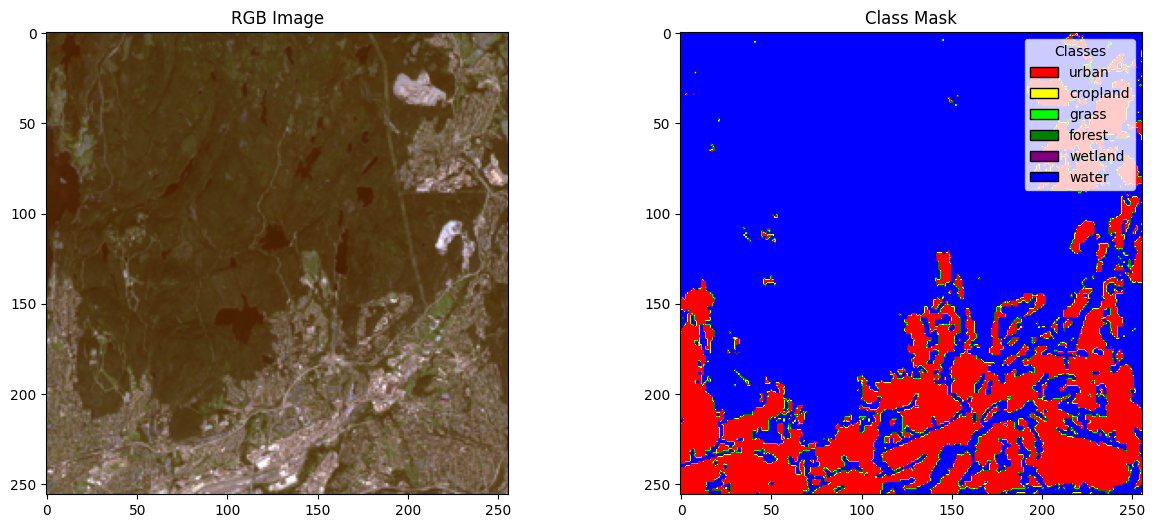

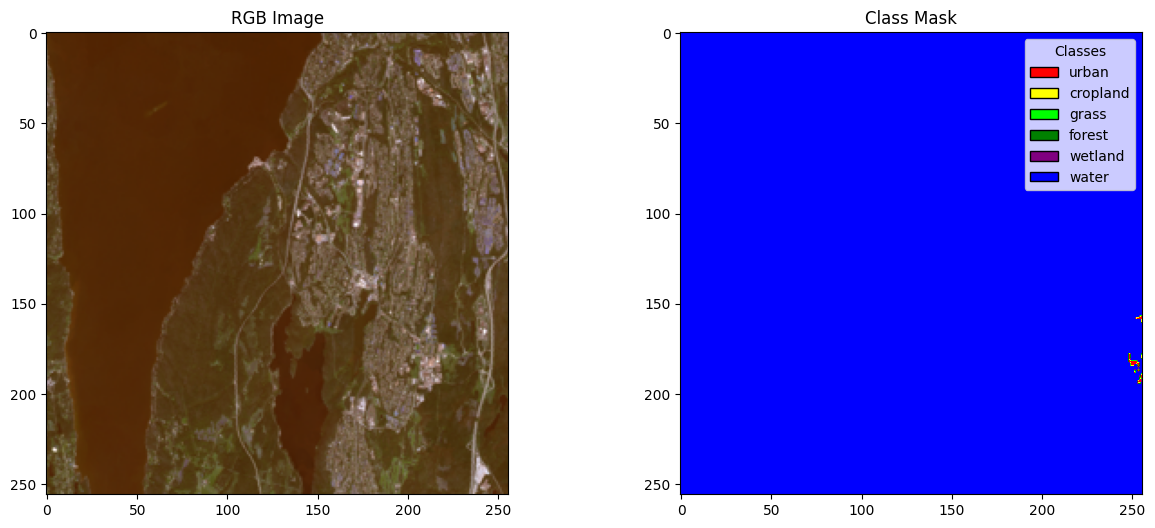

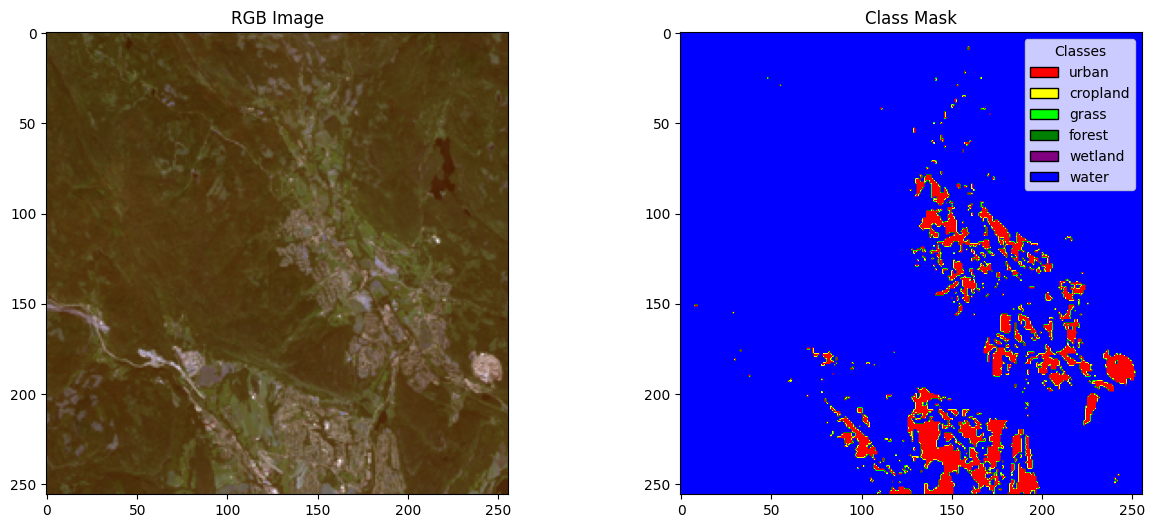

Validation set samples:


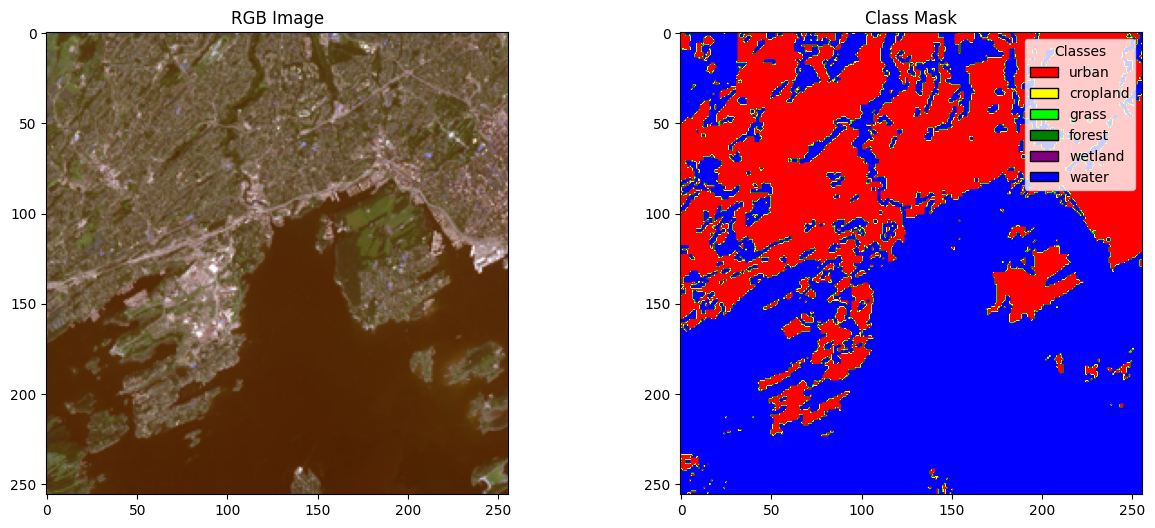

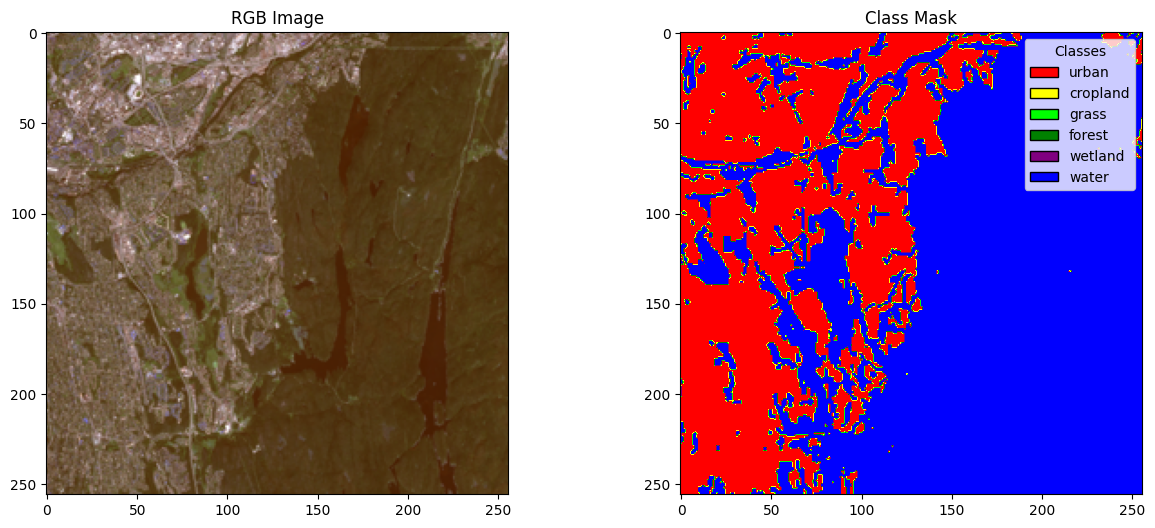

In [64]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

# Define the class labels and corresponding colors
class_labels = ['urban', 'cropland', 'grass', 'forest', 'wetland', 'water']
class_colors = ['red', 'yellow', 'lime', 'green', 'purple', 'blue']

# Function to plot an image and its corresponding mask
def plot_image_and_mask(image, mask, class_colors, class_labels):
    _, axs = plt.subplots(1, 2, figsize=(15, 6))

    # Plot the RGB image
    axs[0].imshow(image / 255.0)
    axs[0].set_title("RGB Image")

    # Plot the mask
    axs[1].imshow(np.argmax(mask, axis=-1), cmap=ListedColormap(class_colors))
    axs[1].set_title("Class Mask")

    # Create legend
    legend_elements = [Patch(facecolor=color, edgecolor='black', label=label) for color, label in zip(class_colors, class_labels)]
    axs[1].legend(handles=legend_elements, loc='upper right', title="Classes")

    plt.show()

# Get the number of samples in training and validation sets
num_train_samples = len(X_train)
num_val_samples = len(X_val)

# Plot some samples from the training set
print("Training set samples:")
for i in range(min(3, num_train_samples)):  # Adjust the range to plot more or fewer images
    plot_image_and_mask(X_train[i], y_train[i], class_colors, class_labels)

# Plot some samples from the validation set
print("Validation set samples:")
for i in range(min(3, num_val_samples)):  # Adjust the range to plot more or fewer images
    plot_image_and_mask(X_val[i], y_val[i], class_colors, class_labels)


# creating a model

In [45]:
num_classes=6

checkpoint_callback = ModelCheckpoint(
    'best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',  # minimize the monitored metric
    verbose=1  # verbosity mode
)

In [57]:
# Define the model
BACKBONE = 'resnet50'
model = sm.Unet(BACKBONE, input_shape=(target_size[0], target_size[1], 3), classes=num_classes, activation='softmax')
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',sm.metrics.iou_score])

history = model.fit(X_train, y_train, batch_size=16, epochs=20, validation_data=(X_val, y_val), callbacks=[checkpoint_callback])

Epoch 1/50
1/1 [==============================] - ETA: 0s - loss: 1.9310 - accuracy: 0.1903 - iou_score: 0.0432
Epoch 1: val_loss improved from 4033.93652 to 2.55231, saving model to best_model.h5
1/1 [==============================] - 29s 29s/step - loss: 1.9310 - accuracy: 0.1903 - iou_score: 0.0432 - val_loss: 2.5523 - val_accuracy: 0.0135 - val_iou_score: 0.0389
Epoch 2/50
1/1 [==============================] - ETA: 0s - loss: 1.6732 - accuracy: 0.3213 - iou_score: 0.0567
Epoch 2: val_loss did not improve from 2.55231
1/1 [==============================] - 0s 96ms/step - loss: 1.6732 - accuracy: 0.3213 - iou_score: 0.0567 - val_loss: 7.2494 - val_accuracy: 0.5104 - val_iou_score: 0.0653
Epoch 3/50
1/1 [==============================] - ETA: 0s - loss: 1.4370 - accuracy: 0.5088 - iou_score: 0.0738
Epoch 3: val_loss did not improve from 2.55231
1/1 [==============================] - 0s 91ms/step - loss: 1.4370 - accuracy: 0.5088 - iou_score: 0.0738 - val_loss: 16.6111 - val_accuracy:

# evaluation

1/1 [==============================] - 0s 22ms/step


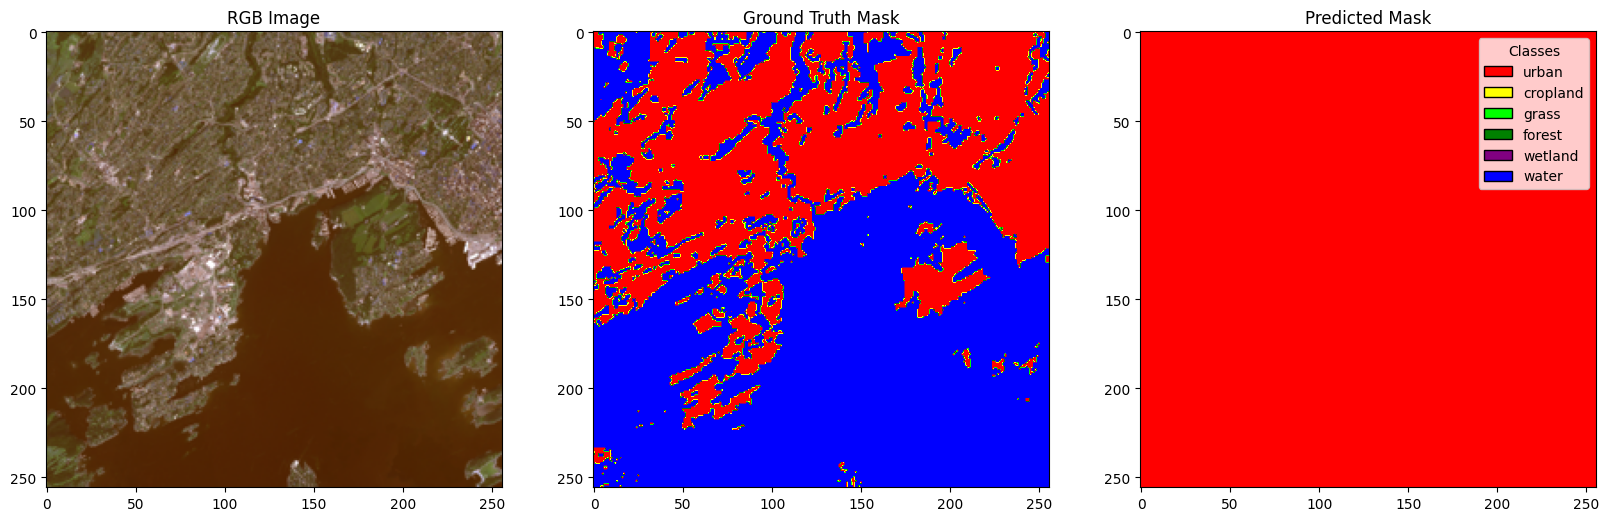

In [61]:
# Define the class labels and corresponding colors
class_labels = ['urban', 'cropland', 'grass', 'forest', 'wetland', 'water']
class_colors = ['red', 'yellow', 'lime', 'green', 'purple', 'blue']

def plot_predictions(model, images, masks, index):
    img = images[index]
    mask = masks[index]

    # Predict the mask
    pred_mask = model.predict(np.expand_dims(img, axis=0))[0]
    pred_mask = np.argmax(pred_mask, axis=-1)

    _, axs = plt.subplots(1, 3, figsize=(20, 6))

    # Plot the RGB image
    axs[0].imshow(img / 255.0)
    axs[0].set_title("RGB Image")

    # Plot the ground truth mask
    axs[1].imshow(np.argmax(mask, axis=-1), cmap=ListedColormap(class_colors))
    axs[1].set_title("Ground Truth Mask")

    # Plot the predicted mask
    axs[2].imshow(pred_mask, cmap=ListedColormap(class_colors))
    axs[2].set_title("Predicted Mask")

    # Create legend
    legend_elements = [Patch(facecolor=color, edgecolor='black', label=label) for color, label in zip(class_colors, class_labels)]
    axs[2].legend(handles=legend_elements, loc='upper right', title="Classes")

    plt.show()

# Plot predictions for a sample index
plot_predictions(model, X_val, y_val, index=0)

In [62]:
def evaluate_model(model, images, masks, num_classes):
    jaccard_scores = []

    for i in range(len(images)):
        img = images[i]
        true_mask = np.argmax(masks[i], axis=-1)

        # Predict the mask
        pred_mask = model.predict(np.expand_dims(img, axis=0))[0]
        pred_mask = np.argmax(pred_mask, axis=-1)

        # Calculate Jaccard score for each class
        for c in range(num_classes):
            true_class = (true_mask == c).astype(int).flatten()
            pred_class = (pred_mask == c).astype(int).flatten()
            score = jaccard_score(true_class, pred_class)
            jaccard_scores.append((c, score))

    # Calculate average Jaccard score per class
    avg_jaccard_scores = {c: np.mean([score for cls, score in jaccard_scores if cls == c]) for c in range(num_classes)}
    
    # Calculate overall average Jaccard score
    overall_avg_jaccard = np.mean(list(avg_jaccard_scores.values()))

    return avg_jaccard_scores, overall_avg_jaccard

# Evaluate the model
avg_jaccard_scores, overall_avg_jaccard = evaluate_model(model, X_val, y_val, num_classes)
print(f"Average Jaccard scores per class: {avg_jaccard_scores}")
print(f"Overall average Jaccard score: {overall_avg_jaccard}")

1/1 [==============================] - 0s 21ms/step
Average Jaccard scores per class: {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.6141357421875}
Overall average Jaccard score: 0.10235595703125
